##  Импорт

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
np.random.seed(10)

## Подготовка данных

In [4]:
num2class = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}
data = np.load('smile_features.npy', allow_pickle=True)
len(data)

999

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=111)

In [7]:
x_train = np.array([i['features'] for i in train_data])
y_train = np.array([i['genre'] for i in train_data])[:, np.newaxis]
x_test = np.array([i['features'] for i in test_data])
y_test = np.array([i['genre'] for i in test_data])[:, np.newaxis]

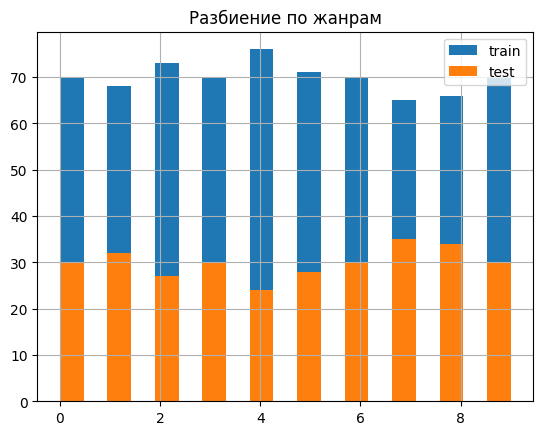

In [8]:

plt.hist([elem['genre'] for elem in train_data], 19, label='train')
plt.hist([elem['genre'] for elem in test_data], 19, label='test')
plt.legend()
plt.title('Разбиение по жанрам')
plt.grid()
plt.show()

## Пример из коллаба

In [9]:
tree_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    random_state=111
)
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=111)

In [10]:
real_class = [elem['genre'] for elem in test_data]
predict_result = list(tree_clf.predict([elem['features'] for elem in test_data]))

In [11]:
print(classification_report(real_class, predict_result))

              precision    recall  f1-score   support

           0       0.45      0.47      0.46        30
           1       0.93      0.81      0.87        32
           2       0.54      0.56      0.55        27
           3       0.33      0.47      0.38        30
           4       0.52      0.62      0.57        24
           5       0.70      0.57      0.63        28
           6       0.69      0.67      0.68        30
           7       0.56      0.40      0.47        35
           8       0.62      0.53      0.57        34
           9       0.23      0.27      0.25        30

    accuracy                           0.53       300
   macro avg       0.56      0.54      0.54       300
weighted avg       0.56      0.53      0.54       300



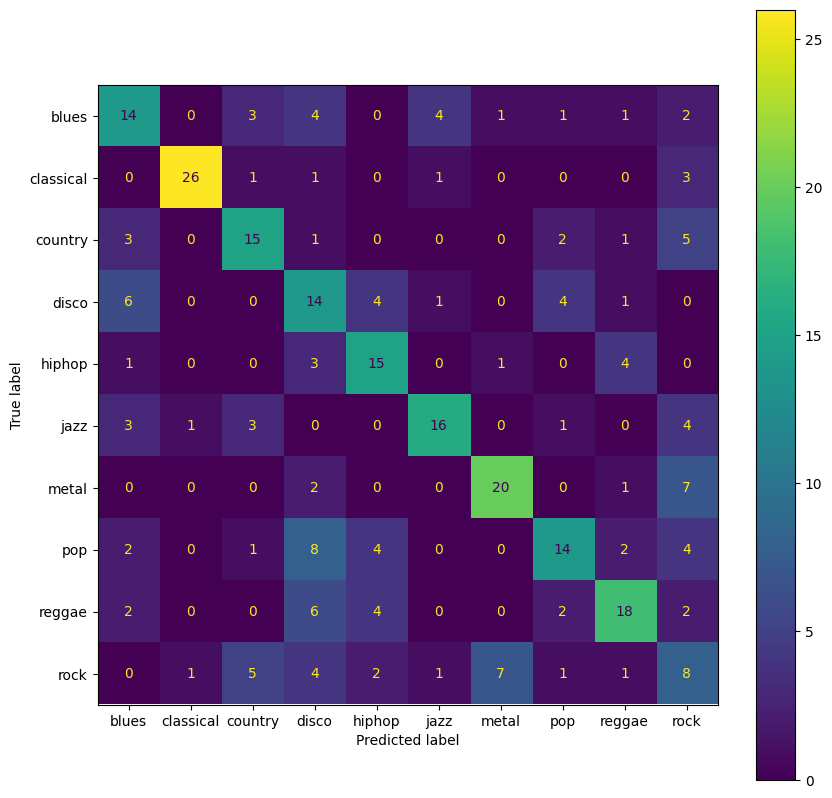

In [12]:
def plot_confusion_matrix(y_true, y_pred):
    y_true_name = [num2class[i] for i in y_true]
    y_pred_name = [num2class[i] for i in y_pred]


    plt.rcParams['figure.figsize'] = [10, 10]
    cm = confusion_matrix(y_true_name, y_pred_name, labels=list(num2class.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(num2class.values()))
    disp.plot()
    plt.show()
plot_confusion_matrix(real_class, predict_result)

## Оптимизируем дерево

### Уменьшение размерности

In [13]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

from sklearn.decomposition import PCA

# PCA to retain 95% of the variance
pca = PCA(n_components=0.98)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

print(f"Original number of features: {x_train_scaled.shape[1]}")
print(f"Reduced number of features: {x_train_pca.shape[1]}")

Original number of features: 6373
Reduced number of features: 517


In [14]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    random_state=111
)
dt_classifier.fit(x_train_pca, y_train)

# Making predictions
y_pred_pca = dt_classifier.predict(x_test_pca)

print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.57      0.40      0.47        30
           1       0.80      0.75      0.77        32
           2       0.50      0.56      0.53        27
           3       0.25      0.20      0.22        30
           4       0.58      0.62      0.60        24
           5       0.52      0.46      0.49        28
           6       0.51      0.60      0.55        30
           7       0.64      0.51      0.57        35
           8       0.42      0.47      0.44        34
           9       0.26      0.37      0.30        30

    accuracy                           0.49       300
   macro avg       0.51      0.49      0.50       300
weighted avg       0.51      0.49      0.50       300



Метрики упали, но мы уменьшили количество переменных. Давайте на уменьшенной размерности найдем лучшие гиперпараметры

### Поиск гиперпараметров после уменьшения размерности

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5]
}

# Grid search for parameter tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=111), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=111),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6]},
             scoring='accuracy')

In [16]:

cv_results = dt_grid_search.cv_results_

results = [(score, params) for score, params in zip(cv_results['mean_test_score'], cv_results['params'])]

sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

for mean_score, params in sorted_results:
    print(f'Mean Test Score {mean_score}')
    for key, value in params.items():
        print(f'\t {key}:{value}')
    print('-'*10)

Mean Test Score 0.5150214592274679
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:1
	 min_samples_split:6
----------
Mean Test Score 0.5150214592274679
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:5
	 min_samples_split:2
----------
Mean Test Score 0.5150214592274679
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:5
	 min_samples_split:4
----------
Mean Test Score 0.5150214592274679
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:5
	 min_samples_split:6
----------
Mean Test Score 0.5092989985693849
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:3
	 min_samples_split:2
----------
Mean Test Score 0.5092989985693849
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:3
	 min_samples_split:4
----------
Mean Test Score 0.5092989985693849
	 criterion:entropy
	 max_depth:10
	 min_samples_leaf:3
	 min_samples_split:6
----------
Mean Test Score 0.5035765379113019
	 criterion:gini
	 max_depth:10
	 min_samples_leaf:1
	 min_samples_split:4
----------
Mean Test S

### Оценка модели на данных исходной размерности

In [17]:
model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=6,
    random_state=111
)
model.fit(x_train, y_train)

# Making predictions
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51        30
           1       0.90      0.81      0.85        32
           2       0.52      0.52      0.52        27
           3       0.35      0.50      0.41        30
           4       0.50      0.50      0.50        24
           5       0.57      0.57      0.57        28
           6       0.69      0.67      0.68        30
           7       0.56      0.51      0.54        35
           8       0.70      0.56      0.62        34
           9       0.28      0.30      0.29        30

    accuracy                           0.55       300
   macro avg       0.56      0.54      0.55       300
weighted avg       0.56      0.55      0.55       300



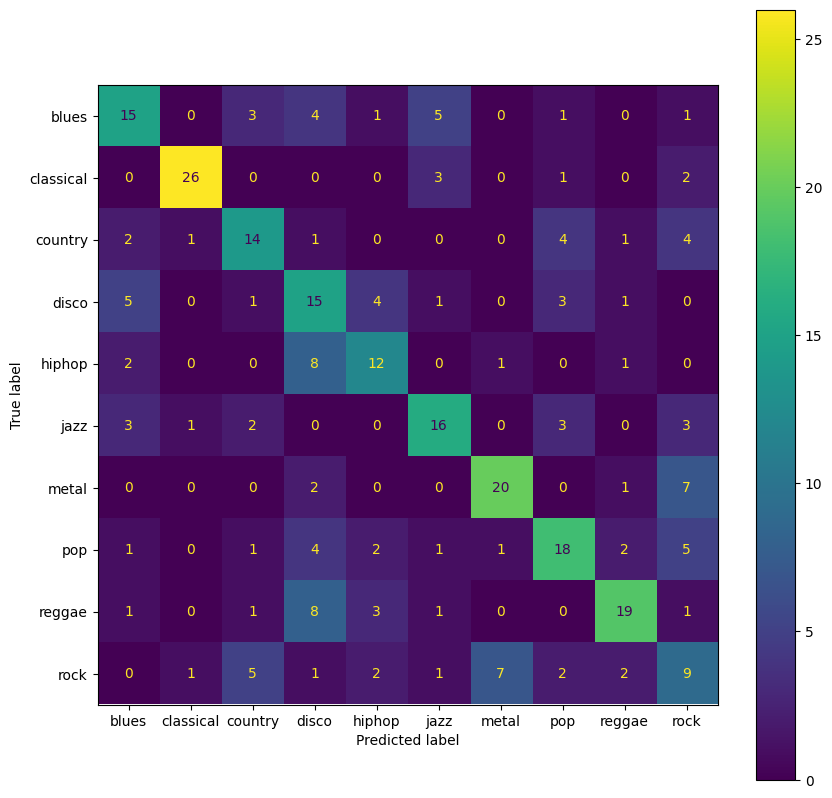

In [18]:
plot_confusion_matrix(list(np.ravel(y_test)), list(y_pred))

Видим, что количество верных предсказаний уменьшилось только у хип-хопа. Что бы это не значило...

### Поиграемся с max_depth

In [19]:
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_leaf':[1],
    'min_samples_split': [6]
}

# Grid search for parameter tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=111), param_grid, cv=4, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=111),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1], 'min_samples_split': [6]},
             scoring='accuracy')

In [20]:
cv_results = dt_grid_search.cv_results_

results = [(score, params) for score, params in zip(cv_results['mean_test_score'], cv_results['params'])]

sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

for mean_score, params in sorted_results:
    print(f'Mean Test Score {mean_score}')
    print(f"max_depth: {params['max_depth']}")
    print('-'*10)

Mean Test Score 0.5064285714285715
max_depth: 5
----------
Mean Test Score 0.49930213464696227
max_depth: 10
----------
Mean Test Score 0.49930213464696227
max_depth: 15
----------


Вывод: параметр MaxDepth особо не влияет на точность.

### Вывод

Лучший результат для DecisionTree получили при следующих гиперпараметрах
model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=6
)

accuracy: 0.55
macro avg: 0.55

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

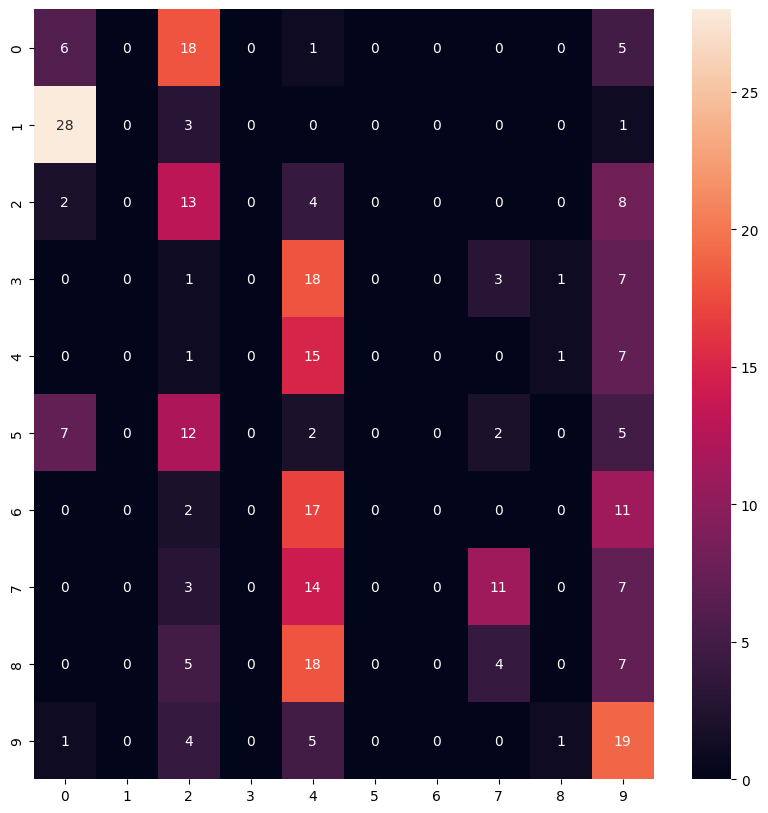

Accuracy: 0.21333333333333335, F1-Score: 0.14636744686743175, Precision: 0.13023687705568282


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns

# Логистическая регрессия с ручными настройками
log_reg = LogisticRegression(max_iter=3000, random_state=111)
log_reg.fit(x_train, y_train)

# Предсказание
y_pred = log_reg.predict(x_test)

# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Вывод результатов
print(f"Accuracy: {acc}, F1-Score: {f1}, Precision: {precision}")


In [22]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.3 MB/s eta 0:00:00


In [23]:
!pip install librosa

In [24]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=20,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='MultiClass',
                           verbose=100,
                           eval_metric='Accuracy')

model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4120172	test: 0.3100000	best: 0.3100000 (0)	total: 18.5s	remaining: 5m 50s
19:	learn: 0.8211731	test: 0.6366667	best: 0.6366667 (19)	total: 4m 10s	remaining: 0us

bestTest = 0.6366666667
bestIteration = 19



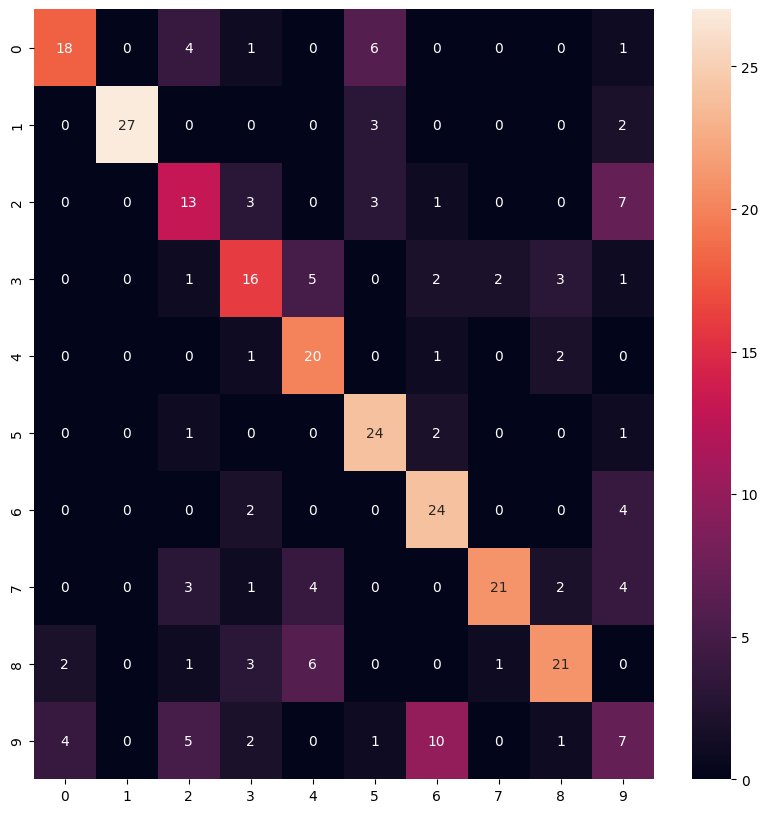

Accuracy: 0.6366666666666667, F1-Score: 0.6323308092442794, Precision: 0.6444484262587712


In [25]:
# Предсказание на тестовом наборе
y_pred = model.predict(x_test)

# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Вывод результатов
print(f"Accuracy: {acc}, F1-Score: {f1}, Precision: {precision}")


<ipython-input-26-6ae0eeb8f090>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = RandomForestClassifier(max_depth=15, max_leaf_nodes=18, n_estimators=100, criterion='gini', random_state=111).fit(x_train_scaled, y_train)


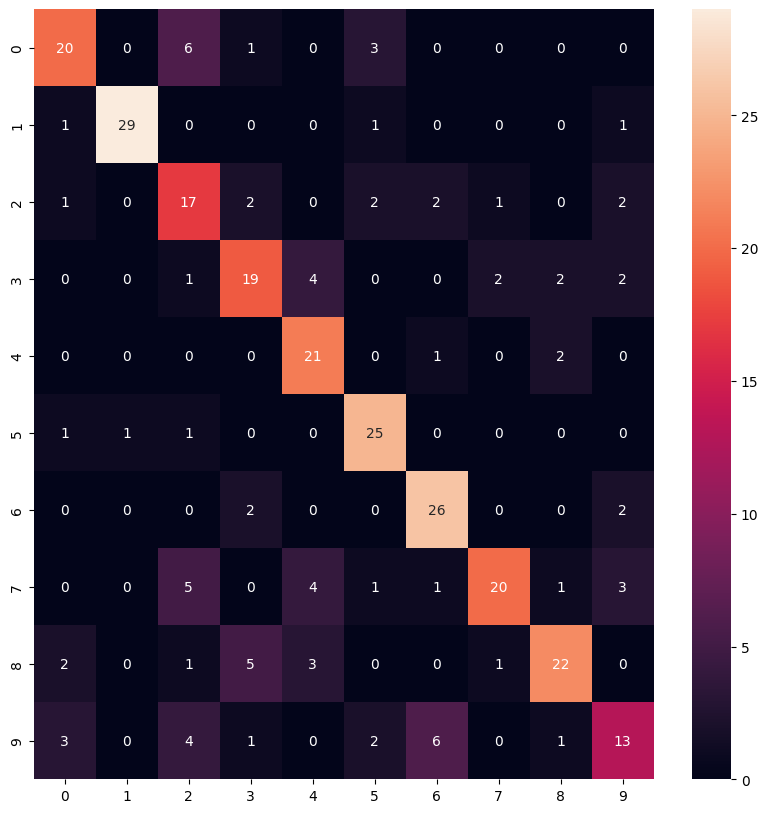

Accuracy: 0.7066666666666667, F1-Score: 0.7029399433056679, Precision: 0.7098031350221248


In [26]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

rfc = RandomForestClassifier(max_depth=15, max_leaf_nodes=18, n_estimators=100, criterion='gini', random_state=111).fit(x_train_scaled, y_train)
y_pred = rfc.predict(x_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Вывод результатов
print(f"Accuracy: {acc}, F1-Score: {f1}, Precision: {precision}")




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

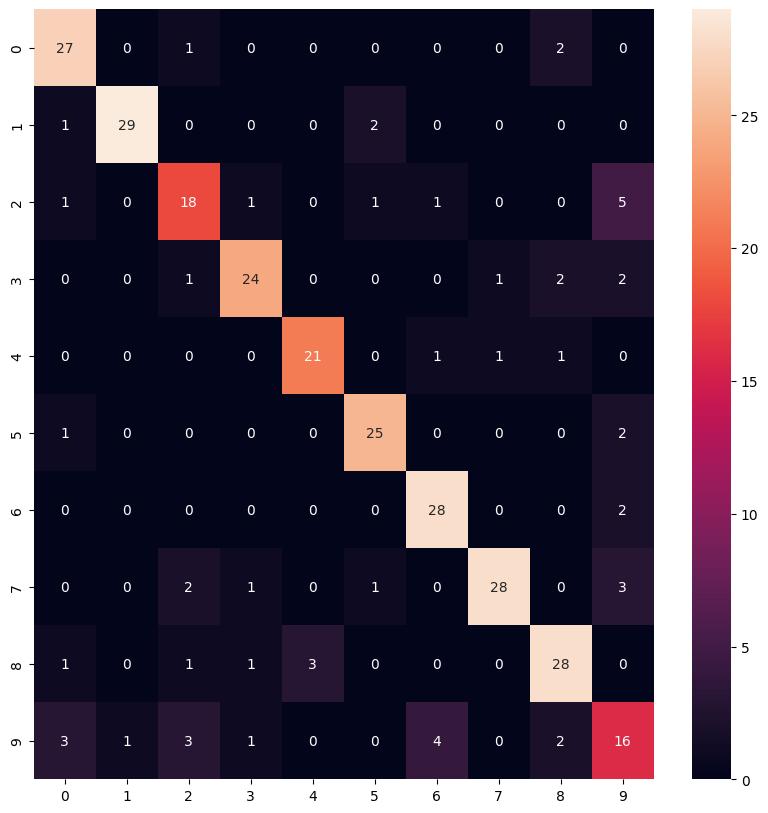

Accuracy: 0.8133333333333334, F1-Score: 0.8119724341109649, Precision: 0.8137499907124652


In [27]:
clf1 = LogisticRegression(C=1, penalty='l2', random_state=111)
clf2 = SVC(C=0.1, gamma='scale', kernel='linear', random_state=111)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(x_train_scaled, y_train)
y_pred = eclf1.predict(x_test_scaled)


# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Вывод результатов
print(f"Accuracy: {acc}, F1-Score: {f1}, Precision: {precision}")

| Модель                                     | Accuracy | F1-score |
|--------------------------------------------|----------|----------|
| DecisionTree                               | 0.55     | 0.55     |   
| CatBoost                                   | 0.63     | 0.63     |
| RandomForest                               | 0.70     | 0.70     |
| Voting: Logistic Regression SVC GaussianNB | 0.81     | 0.81     |